In [4]:
import pandas as pd
import numpy as np
from iso3166 import countries

In [5]:
wf = "wcm"

In [6]:

df_rank_67_79 = pd.read_csv(f'../../data/points67-79.csv')#, index_col=0)
df_rank_79 = pd.read_csv(f'../../data/points79.csv')
df_rank_80_91 = pd.read_csv(f'../../data/points80-91.csv')
df_rank_92 = pd.read_csv(f'../../data/points92.csv')
df_rank_93_now = pd.read_csv(f'../../data/points93-now.csv')

In [7]:
country_translation = {
    "MON": "MCO",
    "MAD": "MDG",
    "CRO": "HRV",
    "BUL": "BGR",
    "ZIM": "ZWE",
    "CKS": "SVK",
    "DAN": "DNK",
    "KOS": "XKX",
    "URS": "RUS",
    "GRE": "GRC",
    "CHI": "CHL",
    "SUI": "CHE",
    "NED": "NLD",
    "IRA": "IRN",
    "LIB": "LBN",
    "SLO": "SVK",
    "LAT": "LVA",
    "GER": "DEU",
    "JUG": "SRB",
    "IRE": "IRL",
    "RSA": "ZAF",
    "SPA": "ESP",
}

In [8]:
def get_alpha2_country(alpha3_name):
    return getattr(countries.get(country_translation.get(alpha3_name, alpha3_name), alpha3_name), "alpha2", "")


In [9]:
def give_parallel_points(position):
    points = {1:100,
              2:80,
              3:60,
              4:50,
              5:40,
              9:15}
    return points.get(position, 0)

In [10]:
def get_points(season):
    df_rank = df_rank_93_now
    if (season < 1979):
        df_rank = df_rank_67_79
    elif (season < 1980):
        df_rank = df_rank_79
    elif (season < 1992):
        df_rank = df_rank_80_91
    elif (season < 1993):
        df_rank = df_rank_92
    else:
        df_rank = df_rank_93_now
        
    return df_rank

In [47]:
for wf in ["wcm", "wcf"]:
    df = pd.read_csv(f'../../data/{wf}.csv').drop(['ath_ski'], axis=1)
    df.ath_country = df.ath_country.apply(get_alpha2_country)
    for season in range(1967, 2021):


        df_rank = get_points(season)

        df_season = df[df["season"] == season]
        df_season = df_season.dropna()

        df_season["ath_rank"]=df_season["ath_rank"].apply(lambda x: np.where(x.isdigit(),x,'0')).astype(int)

        events = df_season[["season", "date", "venue", "country", "event"]].drop_duplicates().reset_index(drop="True")
        events["key"] = 0
        skiers = df_season[["ath_name", "ath_country", "ath_id"]].drop_duplicates().reset_index(drop="True")
        skiers["key"] = 0

        cart_prod = events.merge(skiers, how='outer')

        df_season = pd.merge(cart_prod, df_season,  how='left', left_on=["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"], right_on = ["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"])
        df_season = df_season.fillna(0, downcast='infer')
        df_total = pd.merge(df_season, df_rank, on="ath_rank")
        
        specialty = df_total.groupby(["ath_name", "event"]).points.sum().reset_index()
        specialty = specialty.loc[specialty.groupby('ath_name')['points'].idxmax()].rename(columns={"event": "specialty"}).reset_index().drop(["index", "points"], axis = 1)
        
        df_total = pd.merge(df_total, specialty, on="ath_name")
        
        df_total = df_total.sort_values(by=['date'])
        df_total["value"] = df_total.groupby(['ath_name'])["points"].cumsum()
        
        df_total.rename(columns={"ath_name": "name"})[["date", "name", "ath_country", "value", "specialty"]].to_csv(f"../../web/website/data/{wf}_ranking_{season}.csv", index=False,)
        
        

        df_rank = get_points(season)




        df_season = df[df["season"] == season]
        df_season = df_season.dropna()

        for event in set(df_season.event.tolist()):
            df_season_event = df_season[df_season["event"] == event]

            df_season_event["ath_rank"]=df_season_event["ath_rank"].apply(lambda x: np.where(x.isdigit(),x,'0')).astype(int)

            events = df_season_event[["season", "date", "venue", "country", "event"]].drop_duplicates().reset_index(drop="True")
            events["key"] = 0
            skiers = df_season_event[["ath_name", "ath_country", "ath_id"]].drop_duplicates().reset_index(drop="True")
            skiers["key"] = 0

            cart_prod = events.merge(skiers, how='outer')

            df_season_event = pd.merge(cart_prod, df_season_event,  how='left', left_on=["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"], right_on = ["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"])
            df_season_event = df_season_event.fillna(0, downcast='infer')
            df_total = pd.merge(df_season_event, df_rank, on="ath_rank")
            
            df_total = pd.merge(df_total, specialty, on="ath_name")
        
            df_total = df_total.sort_values(by=['date'])
            

            df_total["value"] = df_total.groupby(['ath_name'])["points"].cumsum()
            df_total.rename(columns={"ath_name": "name"})[["date", "name", "ath_country", "value", "specialty"]].to_csv(f"../../web/website/data/{wf}_{event}_ranking_{season}.csv", index=False,)

/Users/macjol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
set(df.event.tolist())

{'Combined', 'Downhill', 'Giant Slalom', 'Parallel', 'Slalom', 'Super G'}

,ath_name,event,points
0,AJ Hurt,Combined,0
9,Adriana Jelinkova,Parallel,1
13,Aleksandra Prokopyeva,Downhill,9
20,Alexandra Tilley,Giant Slalom,32
28,Ali Nullmeyer,Slalom,27
...,...,...,...
1200,Vivien Insam,Combined,0
1210,Wendy Holdener,Slalom,260
1216,Ylva Staalnacke,Slalom,12
1218,Zazie Huml,Combined,0


In [9]:
for wf in ["wcm", "wcf"]:
    df = pd.read_csv(f'../../data/{wf}.csv').drop(['ath_ski'], axis=1)
    df.ath_country = df.ath_country.apply(get_alpha2_country)
    for season in range(1967, 2021):

        df_rank = get_points(season)




        df_season = df[df["season"] == season]
        df_season = df_season.dropna()

        for event in set(df_season.event.tolist()):
            df_season_event = df_season[df_season["event"] == event]

            df_season_event["ath_rank"]=df_season_event["ath_rank"].apply(lambda x: np.where(x.isdigit(),x,'0')).astype(int)

            events = df_season_event[["season", "date", "venue", "country", "event"]].drop_duplicates().reset_index(drop="True")
            events["key"] = 0
            skiers = df_season_event[["ath_name", "ath_country", "ath_id"]].drop_duplicates().reset_index(drop="True")
            skiers["key"] = 0

            cart_prod = events.merge(skiers, how='outer')

            df_season_event = pd.merge(cart_prod, df_season_event,  how='left', left_on=["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"], right_on = ["season", "date", "venue", "country", "event", "ath_name", "ath_country", "ath_id"])
            df_season_event = df_season_event.fillna(0, downcast='infer')
            df_total = pd.merge(df_season_event, df_rank, on="ath_rank").sort_values(by=['date'])
            df_total["value"] = df_total.groupby(['ath_name'])["points"].cumsum()
            df_total.rename(columns={"ath_name": "name"})[["date", "name", "ath_country", "value"]].to_csv(f"../../web/website/data/{wf}_{event}_ranking_{season}.csv", index=False,)

/Users/macjol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


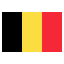

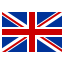

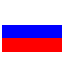

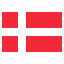

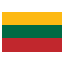

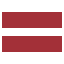

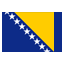

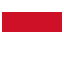

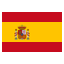

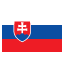

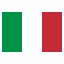

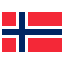

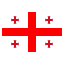

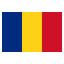

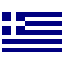

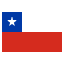

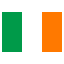

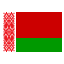

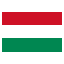

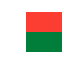

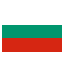

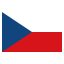

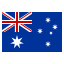

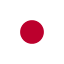

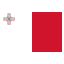

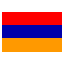

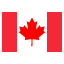

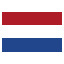

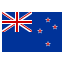

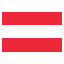

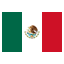

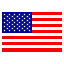

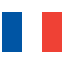

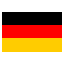

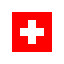

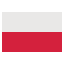

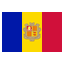

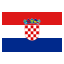

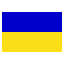

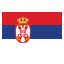

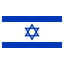

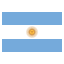

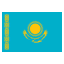

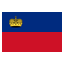

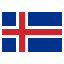

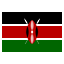

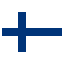

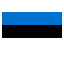

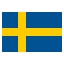

In [10]:
from PIL import Image
import requests
from io import BytesIO
for country in set(df.ath_country.tolist()):
    if country != "":
        response = requests.get(f"https://www.countryflags.io/{country}/flat/64.png")
        img = Image.open(BytesIO(response.content))
        display(img)